# Red wine quality classifier using a Neural network

Data provided by the UCI: https://archive.ics.uci.edu/ml/datasets/wine+quality

### Imports

Libraries import


In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.calibration import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## Supress TensorFlow warnings

In [415]:
# https://weepingfish.github.io/2020/07/22/0722-suppress-tensorflow-warnings/

def import_tensorflow():
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

## Import the Data

In [416]:
tf = import_tensorflow() 

In [417]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [418]:
df.shape

(1599, 12)

In [419]:
dataset = df.values

In [420]:
dataset

array([[ 7.4  ,  0.7  ,  0.   , ...,  0.56 ,  9.4  ,  5.   ],
       [ 7.8  ,  0.88 ,  0.   , ...,  0.68 ,  9.8  ,  5.   ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  0.65 ,  9.8  ,  5.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  0.75 , 11.   ,  6.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  0.71 , 10.2  ,  5.   ],
       [ 6.   ,  0.31 ,  0.47 , ...,  0.66 , 11.   ,  6.   ]])

## Exploratory Data Analysis


Correlation matrix

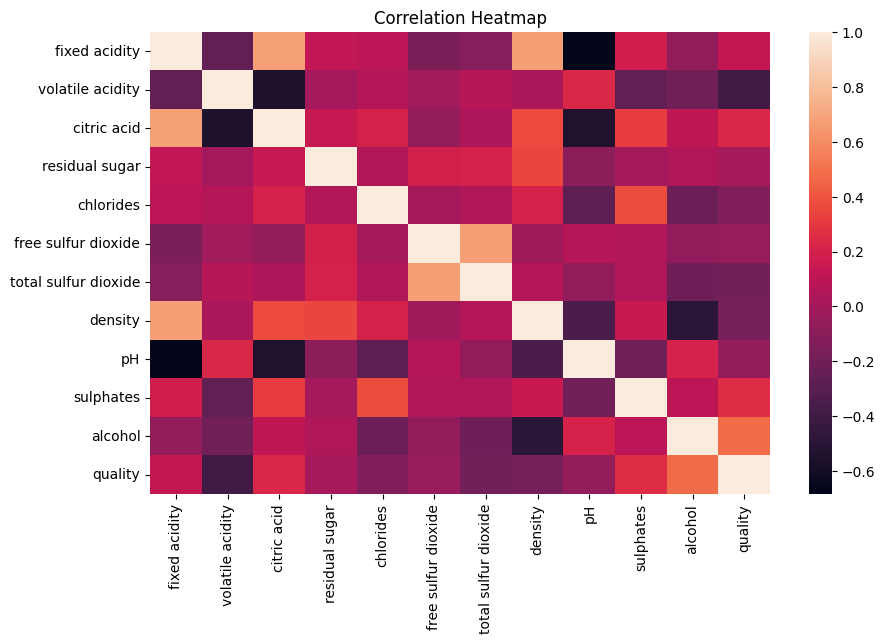

In [421]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot a heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix)
plt.title("Correlation Heatmap")
plt.show()

Scatter plot: Fixed acidity - Density

<Axes: xlabel='fixed acidity', ylabel='density'>

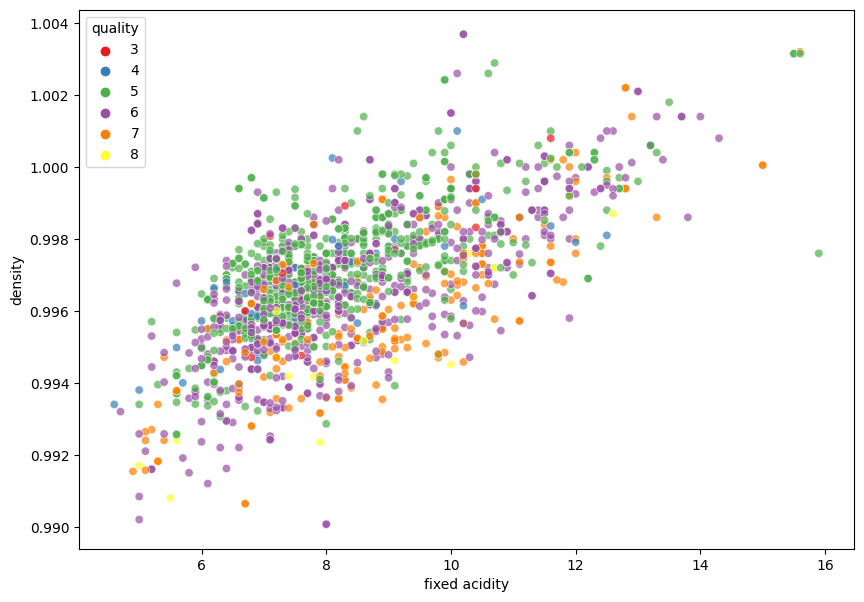

In [422]:
plt.figure(figsize = (10 , 7))
sns.scatterplot(x = "fixed acidity", y = "density", hue = "quality",data = df, alpha = 0.7, palette = "Set1")

Explore the features using histograms

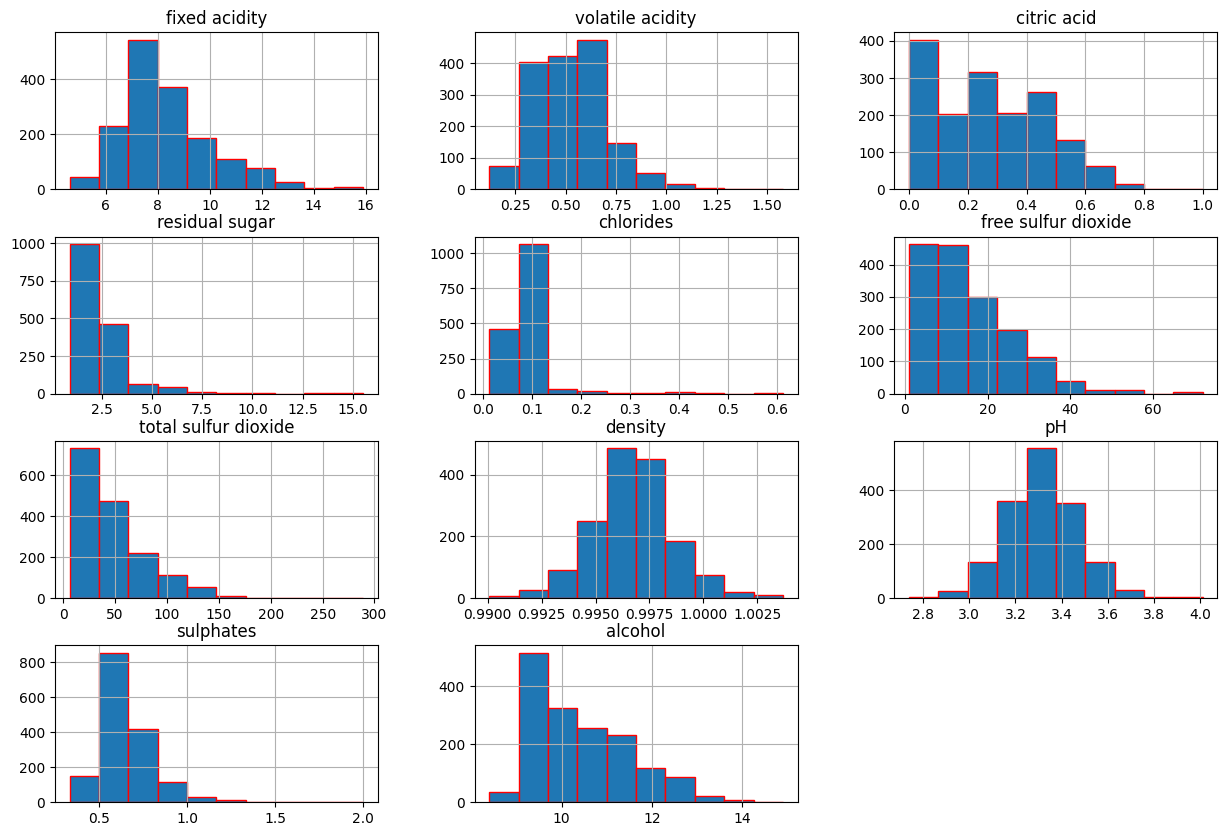

In [423]:
input_variables = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol'
]

# Create histograms for each input variable
df.hist(input_variables , edgecolor = 'red' ,figsize=(15,10))
# display histogram
plt.show()

In [424]:
#Seperating the dataset as response variable and feature variabes
X = df.drop ('quality',axis =1 )

In [425]:
# Define feature columns
feature_columns = []
for feature_name in X.columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

Encoding the quality

In [426]:
X.shape

(1599, 11)

In [427]:
le = LabelEncoder()
y = le.fit_transform(df.iloc[: , -1])
y = pd.DataFrame(y.reshape(len(y),1))

In [428]:
y.shape

(1599, 1)

In [429]:
y.value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: count, dtype: int64

### Spliting data


### Transforming quality to categorical data

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [431]:
# One-hot encode y_train and y_test
y_train_cat = tf.keras.utils.to_categorical(y_train, 6)
y_test_cat = tf.keras.utils.to_categorical(y_test, 6)


In [432]:
y_test_cat

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [433]:
# def traineval(x_train, y_train, training=False, batch_size=128):
#     """An input function for training or evaluating"""
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train))

#     # Shuffle and repeat if you are in training mode.
#     if training:
#         dataset = dataset.shuffle(1000).repeat()

#     return dataset.batch(batch_size)


## Neural Network using TF Estimator DNN Classifier

In [434]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

estimator = tf.estimator.DNNClassifier(
    feature_columns= feature_columns,
    hidden_units=[1024, 512, 256],
    optimizer=optimizer
    )

In [435]:
# estimator.train(
#     input_fn= lambda: traineval(X_train, y_train , training=True), steps=5000)

## Neural Network using TF.Keras

In [436]:
from tensorflow import keras
from tensorflow.keras import layers

ann = tf.keras.models.Sequential(layers = None , name = None)


ann.add(tf.keras.layers.Input(shape = 11,))
ann.add(tf.keras.layers.Dense(units = 256 , activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01) ))
tf.keras.layers.Dropout(0.2)
ann.add(tf.keras.layers.Dense(units = 256 , activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01) ))
tf.keras.layers.Dropout(0.2)
ann.add(tf.keras.layers.Dense(units = 6, activation = "softmax"))
ann.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 256)               3072      
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 70406 (275.02 KB)
Trainable params: 70406 (275.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [437]:
ann.compile(optimizer = 'adam' , loss='mse' ,metrics= ['accuracy'])

In [438]:
hist_1 = ann.fit(
    X_train, y_train_cat,
    batch_size = 128,
    epochs = 250,
    validation_data=(X_test, y_test_cat)
)

Epoch 1/250
10/10 [==============================] - 2s 39ms/step - loss: 2.6890 - accuracy: 0.2627 - val_loss: 2.3304 - val_accuracy: 0.4688
Epoch 2/250
10/10 [==============================] - 0s 11ms/step - loss: 2.1265 - accuracy: 0.4316 - val_loss: 1.8805 - val_accuracy: 0.4750
Epoch 3/250
10/10 [==============================] - 0s 12ms/step - loss: 1.7140 - accuracy: 0.4777 - val_loss: 1.5143 - val_accuracy: 0.5250
Epoch 4/250
10/10 [==============================] - 0s 11ms/step - loss: 1.3828 - accuracy: 0.4715 - val_loss: 1.2254 - val_accuracy: 0.5500
Epoch 5/250
10/10 [==============================] - 0s 12ms/step - loss: 1.1252 - accuracy: 0.4793 - val_loss: 1.0009 - val_accuracy: 0.5813
Epoch 6/250
10/10 [==============================] - 0s 14ms/step - loss: 0.9252 - accuracy: 0.4934 - val_loss: 0.8277 - val_accuracy: 0.5656
Epoch 7/250
10/10 [==============================] - 0s 14ms/step - loss: 0.7725 - accuracy: 0.4941 - val_loss: 0.6953 - val_accuracy: 0.5531
Epoch 

In [439]:
accuracy = ann.evaluate(X_test, y_test_cat)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 0s 4ms/step - loss: 0.0974 - accuracy: 0.5750
Test Accuracy: [0.09741523116827011, 0.574999988079071]


#### loss and validation loss graph

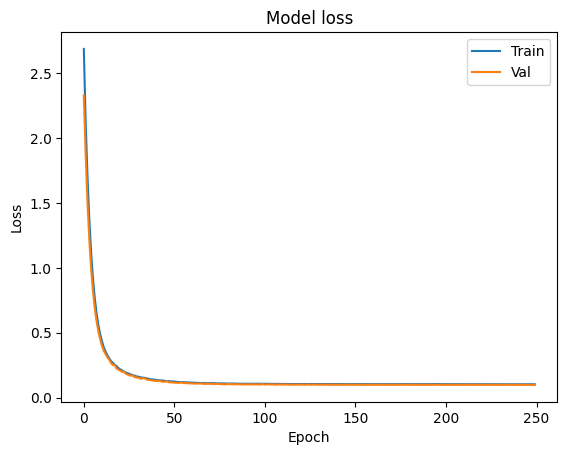

In [440]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### accuracy and validation accuracy

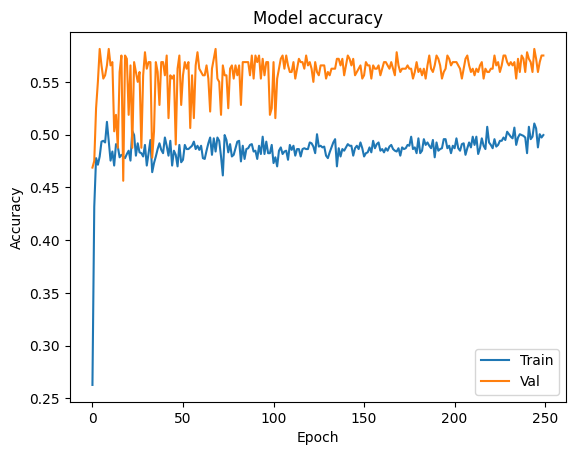

In [441]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## Conclussion 

???